In [1]:
import matplotlib.pyplot as plt
from scipy.stats import describe
import time
import numpy as np
import pandas as pd
import operator
from sympy import symbols, Eq, solve
from sympy import *
import cmath 
import math
from astropy.table import QTable, Table, Column
from astropy import units as u


Se realiza una simulación del camino dado con los parámetros obtenidos para el modelo

Los parámetros a utilizar durante la simulación serán:
$$(a,\rho,\delta,\alpha,\beta,\lambda_0,T)=(0.0,9.616243,1.153579,6.913208,5.615616,0.3,108) $$

In [60]:
a=0;
delta = 1.153579;
rho = 9.616243;
alpha = 6.913208; 
lambda_0 = 0.3;
lambda0 = 0.3;
beta_self = 5.615616;
beta=5.615616;
N_jumps_max = 100000;
T=108;
N_paths=1000;

In [61]:
def simulation2(a,rho,delta,alpha,beta,lambda0,T):
    T0=0
    Nt=[]
    Nt.append(0)
    E=(-1/rho)*(np.log(np.random.uniform(0,1)))
    d1=1+((delta*np.log(np.random.uniform(0,1)))/lambda0-a)
    lambdat=[]
    Ti=[]
    size=[]
    if d1>0:
        S1=(-np.log(d1))/delta
        S2=(-np.log(np.random.uniform(0,1)))/a
        S= min(S1,S2)
    else:
        S2=(-np.log(np.random.uniform(0,1)))/a
        S=S2
    Ti.append(T0+min(S,E))
    lambdamenos=a+(lambda0-a)*np.exp(-delta*(Ti[0]-T0))
    if S<E:
        SJ=np.random.exponential(scale=1/beta)
        lambdat.append(lambdamenos+SJ)
        size.append(SJ)
        N=1
    else:
        EJ=np.random.exponential(scale=1/alpha)
        lambdat.append(lambdamenos+EJ)
        size.append(EJ)
        N=0
    Nt[0]=N
    i=1
    Tx=Ti[-1]
    while Tx<T:
        E=(-1/rho)*(np.log(np.random.uniform(0,1)))
        d1=1+((delta*np.log(np.random.uniform(0,1)))/lambdat[i-1]-a)
        if d1>0:
            S1=(-np.log(d1))/delta
            S2=(-np.log(np.random.uniform(0,1)))/a
            S= min(S1,S2)
        else:
            S2=(-np.log(np.random.uniform(0,1)))/a
            S=S2
        Tx=Ti[i-1]+min(S,E)
        if Tx>T:
            break
        Ti.append(Tx)
        lambdamenos=a+(lambdat[i-1]-a)*np.exp(-delta*(Ti[i]-Ti[i-1]))
        if S<E:
            SJ=np.random.exponential(scale=1/beta)
            lambdat.append(lambdamenos+SJ)
            size.append(SJ)
            N=1+N
        else:
            EJ=np.random.exponential(scale=1/alpha)
            lambdat.append(lambdamenos+EJ)
            size.append(EJ)
            N=0+N
        Nt.append(N)
        i=i+1
        if i==1000000:
            break
    return Ti,Nt,N,lambdat,size

In [86]:
Ti,Nt,N,lambdat,size=simulation2(a,rho,delta,alpha,beta,lambda0,T)
max(Nt)

C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


154

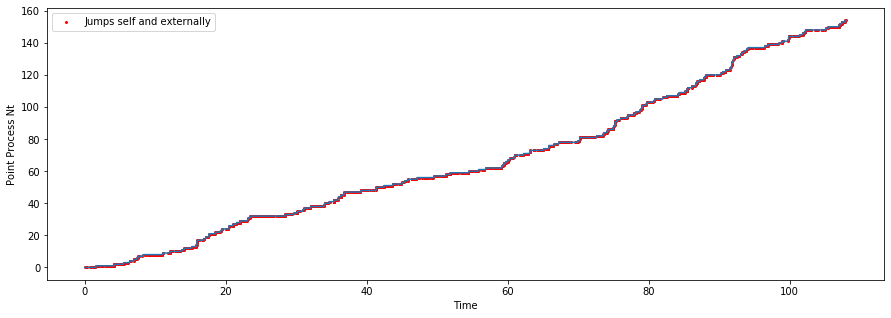

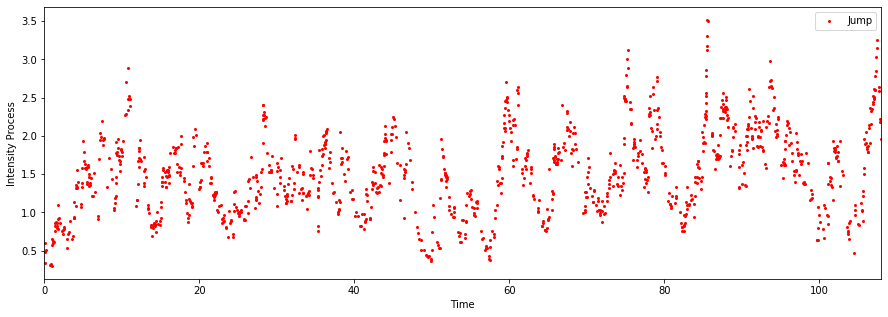

In [87]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        intr=Nt[0]
        
    else:
        intr=Nt[i]-Nt[i-1]
    Nt_final.append(intr)    
    i=i+1
    if i ==10000000:
        break

#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

plt.figure(figsize=(15,5))
plt.scatter(Ti,Nt,label='Jumps self and externally',color='red',s=4)
plt.step(Ti,Nt,where='post')
#plt.title('Ti vs Nt')
plt.xlabel('Time')
plt.ylabel('Point Process Nt')
plt.legend()
plt.savefig("conteo_app.jpg", bbox_inches='tight')

plt.figure(figsize=(15,5))
plt.xlim(0,T)
plt.scatter(Ti,lambdat,label='Jump',color='red',s=4)
plt.xlabel('Time')
plt.ylabel('Intensity Process')
plt.legend()
plt.savefig("intensidad_app.jpg", bbox_inches='tight')

Generación del Proceso de Contagio Dinámico

In [91]:
def DCP_generator(a,rho,delta,alpha,beta,lambda0,T,N_paths,N_jumps_max):
    N_T=np.zeros(N_paths)
    for j_path in range (0,N_paths):
        T_jump=np.zeros(N_jumps_max+1)
        T_jump[0]=0
        T_self=np.zeros(N_jumps_max+1)
        T_self[0]=0
        lambda_p=np.zeros(N_jumps_max+1)
        lambda_p[0]=lambda0
        lambda_n=np.zeros(N_jumps_max+1)
        lambda_n[0]=lambda0
        for i_jump in range(0,N_jumps_max):
            E=(-1/rho)*np.log(np.random.rand())
            d=1+((delta*np.log(np.random.rand()))/lambda_p[i_jump])
            if (d>0):
                S=(-1/delta)*np.log(d)
            elif (d<0):
                S=np.inf
            tau=min(S,E)
            T_jump[i_jump+1]=T_jump[i_jump]+tau
            if (tau==S):
                Y_size=(-1/beta)*np.log(np.random.rand())
                T_self[i_jump+1]=1
            elif (tau==E):
                Y_size=(-1/alpha)*np.log(np.random.rand())
                T_self[i_jump+1]=0
            lambda_n[i_jump+1]=lambda_p[i_jump]*np.exp(-delta*tau)
            lambda_p[i_jump+1]=lambda_n[i_jump+1]+Y_size
            if T_jump[i_jump+1]>T:
                N_T[j_path]=np.sum(T_self[0:i_jump])
                break
    return N_T,T_jump,T_self,lambda_p

In [92]:
N_T,T_jump,T_self,lambda_p=DCP_generator(a,rho,delta,alpha,beta,lambda0,T,N_paths,N_jumps_max)

In [93]:
N_T

array([163., 126., 144., 194., 145., 170., 104., 152., 176., 157., 154.,
       159., 144., 185., 163., 146., 172., 166., 153., 177., 143., 125.,
       164., 164., 153., 147., 145., 161., 164., 133., 136., 156., 158.,
       147., 182., 172., 138., 137., 148., 165., 129., 151., 148., 149.,
       179., 159., 152., 157., 141., 126., 159., 136., 164., 179., 155.,
       167., 149., 145., 168., 143., 153., 167., 135., 203., 151., 164.,
       148., 142., 165., 142., 163., 147., 169., 154., 155., 135., 141.,
       165., 159., 154., 155., 155., 158., 176., 160., 155., 158., 142.,
       134., 164., 166., 144., 169., 171., 148., 153., 131., 121., 147.,
       130., 158., 137., 147., 174., 163., 150., 132., 133., 166., 158.,
       130., 177., 131., 144., 134., 136., 185., 129., 113., 125., 152.,
       136., 158., 115., 175., 113., 125., 122., 189., 150., 174., 118.,
       137., 158., 140., 166., 156., 151., 136., 142., 161., 161., 150.,
       144., 152., 158., 175., 172., 146., 177., 17

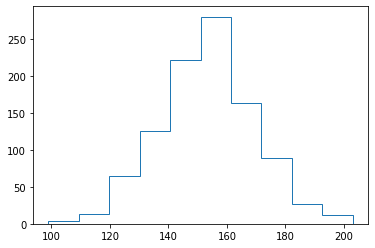

In [102]:
plt.hist(N_T, histtype='step')
plt.savefig("bar_app.jpg", bbox_inches='tight')

Se realiza la simulación de la probabilidad de ruina para una reserva inicial y la prima proporcional al IBC del empleado

In [163]:
n=3 # Number of SMMLV
SMMLV=877803 #$Cop
t_bef=60 #months
risk_exposure=2.436/100 #2.436% Risk III 
c=n*risk_exposure*SMMLV
x_0=c*t_bef 

In [164]:
gamma=1/447736;

In [165]:
(x_0,c)

(3848990.5944000003, 64149.84324)

In [187]:
z=[]
i=0
while i<len(Nt):
    y=np.random.exponential(scale=1/gamma)
    z.append(y)
    i=i+1
    if i==200000:
        break

In [188]:
mu1H=1/alpha
mu1G=1/beta
mu1Z=1/gamma
net=((mu1H* rho + a * delta)*mu1Z)/(delta-mu1G)
if c>net:
    print('Satisfy the Net Profit Condition')
else:
    print('Does not satisfy the Net Profit Condition')


Does not satisfy the Net Profit Condition


In [189]:
#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        h=Nt[0]
        
    else:
        h=Nt[i]-Nt[i-1]
    Nt_final.append(h)    
    i=i+1
    if i ==10000000:
        break

In [190]:
#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

#Tamaño de los saltos internos
z_S = list(map(operator.mul, z, Nt_final))

X_t=[]
i=0
while i<len(Ti):
    xt=x_0+c*(Ti[i])-np.cumsum(z_S)[i]
    X_t.append(xt)
    i=i+1
    if i==2000000:
        break

In [191]:
i=0
h=0
X_t_2=X_t
Ti_2=Ti
while i < len(z_S):
    if z_S[i]!=0:
        
        X_t_a=X_t_2[:i+h]
        X_t_a.append(z_S[i]+X_t[i])
        X_t_b=X_t_2[i+h:]
        X_t_2=X_t_a+X_t_b
        
        Ti_a=Ti_2[:i+h]
        Ti_a.append(Ti[i])
        Ti_b=Ti_2[i+h:]
        Ti_2=Ti_a+Ti_b
        h+=1
    i+=1

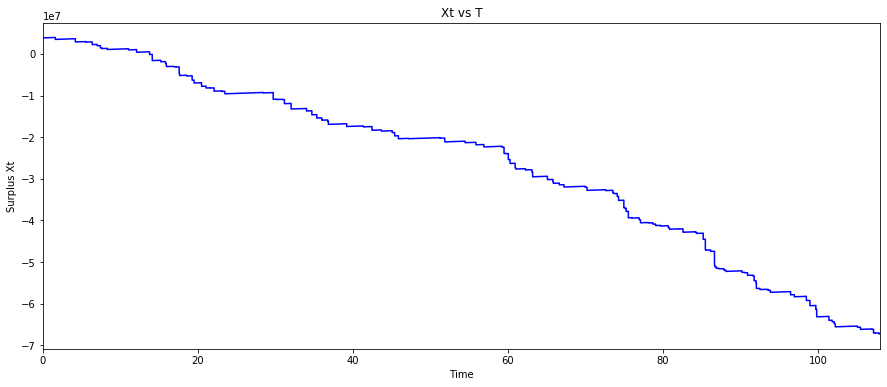

In [192]:
plt.figure(figsize=(15,6))
plt.plot(Ti_2,X_t_2,color='blue')
plt.title('Xt vs T')
plt.xlim(0,T)
#plt.ylim(np.min(X_t_2),np.max(X_t_2)+10)
plt.xlabel('Time')
plt.ylabel('Surplus Xt')
plt.savefig("surplus_app.jpg", bbox_inches='tight')

In [193]:
if min(X_t_2)<0:
    print('Valor mínimo adicional en la reserva para no tener ruina a noviembre de 2020:',abs(min(X_t_2))) #A la fecha del 2020 buscar fecha.
else:
    print('El valor que aún permanece en la reserva en noviembre de 2020 es:',abs(min(X_t_2)))

Valor mínimo adicional en la reserva para no tener ruina a noviembre de 2020: 67282752.51854505


In [194]:
abs(min(X_t_2))+x_0-68434847

2696896.11294505

Cambiando la ventana de tiempo a 180 meses, es decir, realizando una predicción donde los parámetros no son dinámicos se obtienen lo siguientes resultados.

In [195]:
T=180;

In [196]:
Ti,Nt,N,lambdat,size=simulation2(a,rho,delta,alpha,beta,lambda0,T)
max(Nt)

C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\hsrc_\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


256

Does not satisfy the Net Profit Condition


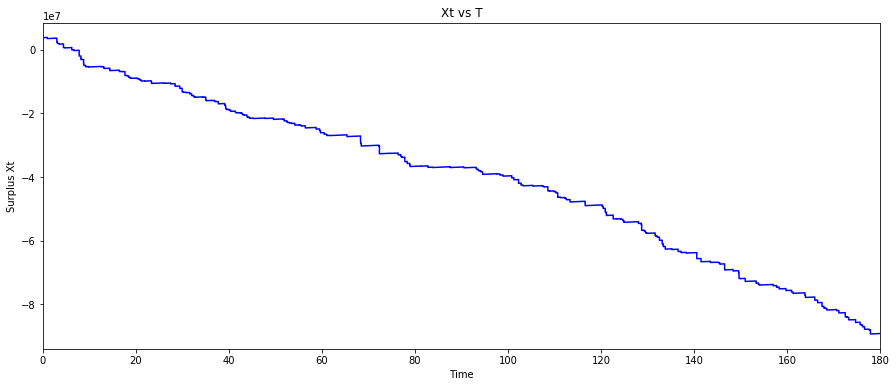

In [199]:
z=[]
i=0
while i<len(Nt):
    y=np.random.exponential(scale=1/gamma)
    z.append(y)
    i=i+1
    if i==200000:
        break

mu1H=1/alpha
mu1G=1/beta
mu1Z=1/gamma
net=((mu1H* rho + a * delta)*mu1Z)/(delta-mu1G)
if c>net:
    print('Satisfy the Net Profit Condition')
else:
    print('Does not satisfy the Net Profit Condition')


#Conteo del número de saltos internos
i=0
Nt_final=[]
while i <(len(Nt)):
    
    if i==0:
        h=Nt[0]
        
    else:
        h=Nt[i]-Nt[i-1]
    Nt_final.append(h)    
    i=i+1
    if i ==10000000:
        break

#Tiempos de saltos internos
Ti_S = list(map(operator.mul, Ti, Nt_final))

#Tamaño de los saltos internos
z_S = list(map(operator.mul, z, Nt_final))

X_t=[]
i=0
while i<len(Ti):
    xt=x_0+c*(Ti[i])-np.cumsum(z_S)[i]
    X_t.append(xt)
    i=i+1
    if i==2000000:
        break

i=0
h=0
X_t_2=X_t
Ti_2=Ti
while i < len(z_S):
    if z_S[i]!=0:
        
        X_t_a=X_t_2[:i+h]
        X_t_a.append(z_S[i]+X_t[i])
        X_t_b=X_t_2[i+h:]
        X_t_2=X_t_a+X_t_b
        
        Ti_a=Ti_2[:i+h]
        Ti_a.append(Ti[i])
        Ti_b=Ti_2[i+h:]
        Ti_2=Ti_a+Ti_b
        h+=1
    i+=1

plt.figure(figsize=(15,6))
plt.plot(Ti_2,X_t_2,color='blue')
plt.title('Xt vs T')
plt.xlim(0,T)
#plt.ylim(np.min(X_t_2),np.max(X_t_2)+10)
plt.xlabel('Time')
plt.ylabel('Surplus Xt')
plt.savefig("surplus2_app.jpg", bbox_inches='tight')

In [200]:
if min(X_t_2)<0:
    print('Valor mínimo adicional en la reserva para no tener ruina a noviembre de 2020:',abs(min(X_t_2))) #A la fecha del 2020 buscar fecha.
else:
    print('El valor que aún permanece en la reserva en noviembre de 2020 es:',abs(min(X_t_2)))

Valor mínimo adicional en la reserva para no tener ruina a noviembre de 2020: 89379285.7244703


Generación para un portafolio 

Los parámetros a utilizar durante la simulación serán:
$$(a,\rho,\delta,\alpha,\beta,\lambda_0,T)=(0.0,0.023654,0.266699,0.423671,4.394793,0.3,108) $$

In [222]:
delta=0.266699;
beta=4.394793;
beta_self=4.394793;
rho=0.023654;
alpha=0.423671;
a=0;
lambda_0 = 0.3;
lambda0 = 0.3;
N_jumps_max = 100000;
T=108;
N_paths=1000;

In [223]:
N_T,T_jump,T_self,lambda_p=DCP_generator(a,rho,delta,alpha,beta,lambda0,T,N_paths,N_jumps_max)

In [224]:
N_T

array([2.200e+01, 5.300e+02, 5.700e+01, 6.200e+01, 2.500e+02, 1.530e+02,
       1.710e+02, 1.120e+02, 2.330e+02, 9.800e+01, 0.000e+00, 2.000e+00,
       2.950e+02, 2.510e+02, 2.860e+02, 6.300e+01, 1.000e+01, 1.040e+02,
       1.840e+02, 7.900e+01, 4.700e+01, 2.920e+02, 4.000e+00, 6.500e+01,
       8.500e+01, 8.000e+01, 0.000e+00, 1.430e+02, 0.000e+00, 0.000e+00,
       3.370e+02, 1.000e+00, 2.000e+00, 1.820e+02, 2.440e+02, 1.200e+01,
       2.070e+02, 2.030e+02, 1.400e+01, 7.360e+02, 1.050e+02, 1.580e+02,
       8.700e+01, 9.700e+01, 1.690e+02, 1.560e+02, 4.700e+01, 1.280e+02,
       2.400e+02, 0.000e+00, 1.430e+02, 2.400e+01, 1.830e+02, 8.500e+01,
       7.000e+00, 3.780e+02, 3.570e+02, 3.000e+00, 1.150e+02, 6.800e+01,
       4.700e+01, 2.300e+02, 0.000e+00, 3.000e+00, 2.110e+02, 9.400e+01,
       2.000e+00, 6.500e+01, 5.000e+00, 3.800e+01, 2.440e+02, 3.800e+01,
       1.450e+02, 1.600e+01, 2.690e+02, 2.000e+00, 2.610e+02, 1.390e+02,
       3.870e+02, 1.780e+02, 6.800e+01, 8.000e+00, 

In [225]:
np.mean(N_T)

129.171

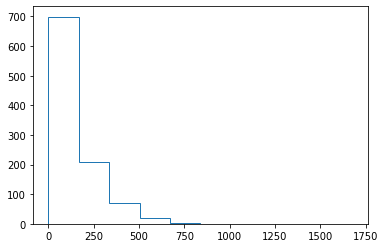

In [226]:
plt.hist(N_T, histtype='step')
plt.savefig("hist_app.jpg", bbox_inches='tight')